<a href="https://colab.research.google.com/github/casjunior93/Desafio-Dio---Treinamento-da-Rede-YOLO-com-transfer-learning/blob/main/Detec%C3%A7%C3%A3o_com_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Dio - Treinamento da Rede YOLO com transfer learning

Conectando com o Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (82.5 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123069 files and directories currently install

Checando a versão do CUDA - Já vem pré-instalado no Colab

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Necessário instalar o cuDNN de acordo com a versão do CUDA

Para isso, é preciso [baixar o cuDNN](https://developer.nvidia.com/rdp/cudnn-archive) do site da Nvidia levando em consideração a versão do CUDA verificado anteriormente. Para a versão 11 do Cuda, instalei a [versão v8.0.1 RC2 (June 26th, 2020)](https://developer.nvidia.com/compute/machine-learning/cudnn/secure/8.0.1.13/11.0_20200626/cudnn-11.0-linux-x64-v8.0.1.13.tgz) do cuDNN.

In [ ]:
!tree /content/gdrive/MyDrive/darknet

/content/gdrive/MyDrive/darknet [error opening dir]

0 directories, 0 files


Descompactando na mesma pasta do Cuda na VM.

In [ ]:
!tar -xzvf /content/gdrive/MyDrive/darknet/cuDNN/cudnn-11.0-linux-x64-v8.0.1.13.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

tar (child): /content/gdrive/MyDrive/darknet/cuDNN/cudnn-11.0-linux-x64-v8.0.1.13.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
chmod: cannot access '/usr/local/cuda/include/cudnn.h': No such file or directory


In [ ]:
#!tree /usr/local/cuda/

# Instalando o Darknet

In [ ]:
# A versão !git clone https://github.com/pjreddie/darknet trouxe problemas com na compilação da darknet que não consegui resolver.
!git clone https://github.com/AlexeyAB/darknet/
%cd darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15521, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15521 (delta 0), reused 4 (delta 0), pack-reused 15514
Receiving objects: 100% (15521/15521), 14.17 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (10413/10413), done.
/content/darknet


In [ ]:
!ls

3rdparty		darknet_video.py       net_cam_v4.sh
build			data		       README.md
build.ps1		image_yolov3.sh        results
cfg			image_yolov4.sh        scripts
cmake			include		       src
CMakeLists.txt		json_mjpeg_streams.sh  vcpkg.json
DarknetConfig.cmake.in	LICENSE		       vcpkg.json.opencv23
darknet_images.py	Makefile	       video_yolov3.sh
darknet.py		net_cam_v3.sh	       video_yolov4.sh


In [ ]:
!git checkout feature/google-colab

error: pathspec 'feature/google-colab' did not match any file(s) known to git


Compilando o darknet

In [ ]:
!make
#!cp ./darknet /content/gdrive/MyDrive/darknet/bin/darknet

In [ ]:
!chmod +x ./darknet

Funções úteis

In [ ]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()


def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

Obtendo pesos Yolov3

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-06-20 03:42:17--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  62.2MB/s    in 4.1s    

2023-06-20 03:42:21 (58.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



**NOTA:** O teste a seguir só funcionará quando a darknet for compilada no tempo de execução. Esta demonstração usa alguns dados das pastas originais da darknet. Para seus projetos de detecção de objetos, você terá esses arquivos necessários em sua pasta local.

 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv    128  

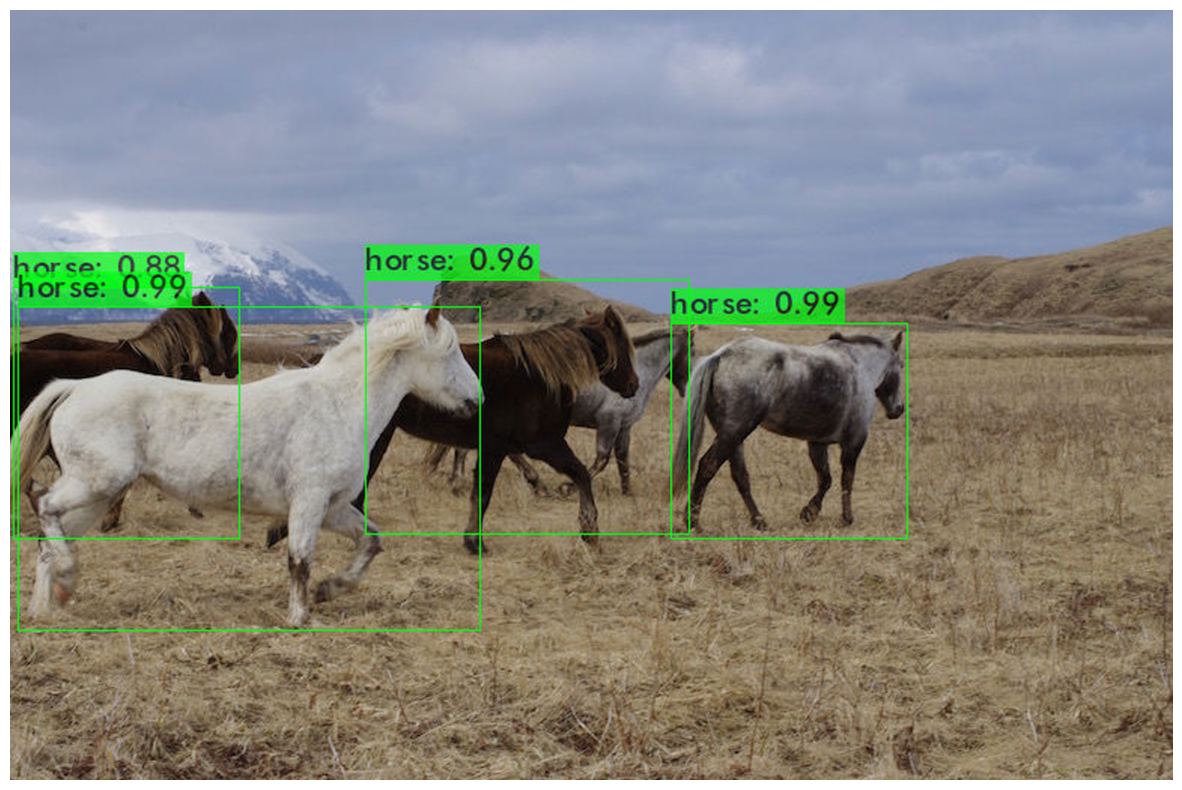

In [ ]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect cfg/yolov3.cfg yolov3.weights data/horses.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## Imagens usadas para treino

Vamos usar um conjunto de dados que contém imagens de dois aquários nos Estados Unidos. Contém 638 imagens no total.  O conjunto de dados fornece anotações para diferentes tipos de criaturas nesses aquários. As classes para as quais as anotações estão disponíveis são **peixes, águas-vivas, pinguins, tubarões, papagaios-do-mar, arraias e estrelas-do-mar**.

Link do conjunto de imagens: [link](https://public.roboflow.com/object-detection/aquarium)

Copiando as imagens para a vm e extraindo na pasta img.

In [ ]:
import os

# Verificar se a pasta existe
if not os.path.exists('./img'):
    # Criar a pasta
    os.makedirs('./img')
    print("Pasta 'img' criada com sucesso!")
else:
    print("A pasta 'img' já existe.")

Pasta 'img' criada com sucesso!


In [ ]:
# Copy your compressed file
!cp -r "/content/gdrive/MyDrive/Datasets/aquario-darknet/aquario-darknet.zip" ./img/aquario-darknet.zip

# Uncompress zipped file
!unzip ./img/aquario-darknet.zip -d ./img/

Criando arquivos train.txt, test.txt e valid.txt:

In [ ]:
import os

def salvar_caminhos_em_txt(pasta, nome_arquivo):
    caminhos = []
    extensoes_validas = ['.jpg', '.jpeg', '.png']

    for root, dirs, files in os.walk(pasta):
        for file in files:
            extensao = os.path.splitext(file)[1].lower()
            if extensao in extensoes_validas:
                caminho = os.path.join(root, file)
                caminhos.append(caminho)

    with open(nome_arquivo, 'w') as arquivo:
        arquivo.write('\n'.join(caminhos))

In [ ]:
# Caminhos das pastas
pasta_train = './img/train'
pasta_test = './img/test'
pasta_valid = './img/valid'

# Salvar caminhos das imagens da pasta "train"
salvar_caminhos_em_txt(pasta_train, './img/train.txt')

# Salvar caminhos das imagens da pasta "test"
salvar_caminhos_em_txt(pasta_test, './img/test.txt')

# Salvar caminhos das imagens da pasta "valid"
salvar_caminhos_em_txt(pasta_valid, './img/valid.txt')

Criando obj.names:

In [ ]:
def create_obj_names(class_names, file_path):
    with open(file_path, "w") as file:
        for class_name in class_names:
            file.write(class_name + "\n")

# Exemplo de uso
class_names = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
file_path = "./img/obj.names"
file_path2 = "./cfg/coco.names"

create_obj_names(class_names, file_path)
create_obj_names(class_names, file_path2)

Criando obj.data:

In [ ]:
def create_obj_data(classes, train_path, test_path, valid_path, names_path, backup_path, pretrained_weights):
    data_content = f"classes = {classes}\n"
    data_content += f"train = {train_path}\n"
    data_content += f"test = {test_path}\n"
    data_content += f"valid = {valid_path}\n"
    data_content += f"names = {names_path}\n"
    data_content += f"backup = {backup_path}\n"
    data_content += f"pretrained_weights = {pretrained_weights}\n"

    with open("./img/obj.data", "w") as file:
        file.write(data_content)
    with open("./cfg/coco.data", "w") as file:
        file.write(data_content)

# Exemplo de uso
classes = 7
train_path = "./img/train.txt"
valid_path = "./img/valid.txt"
test_path = "./img/test.txt"
names_path = "./img/obj.names"
backup_path = "backup/"
pretrained_weights = "yolov3.weights"

create_obj_data(classes, train_path, test_path, valid_path, names_path, backup_path, pretrained_weights)

Faça download do arquivo /content/darknet/cfg/yolov3.cfg. No final do arquivo, você encontrará três seções [yolo]. Certifique-se de que o valor de classes em cada seção seja igual ao número de classes em seu conjunto de dados. Modifique também os valores de width e
height. No caso deste datasets, as imagens tem valores de width=768 e
height=1024.
Depois faça upload na pasta ./img.

Mais mudanças:
* batch=64
* subdivisions=16

Nas camadas convolucionais anteriores às camadas Yolo, configurei filters=36.

## Executando o transfer learning

In [ ]:
!./darknet detector train "img/obj.data" "img/yolov3.cfg" "yolov3.weights" -dont_show

 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
yolov3
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    768 x1024 x   3 ->  768 x1024 x  32 1.359 BF
   1 conv     64       3 x 3/ 2    768 x1024 x  32 ->  384 x 512 x  64 7.248 BF
   2 conv     32       1 x 1/ 1    384 x 512 x  64 ->  384 x 512 x  32 0.805 BF
   3 conv     64       3 x 3/ 1    384 x 512 x  32 ->  384 x 512 x  64 7.248 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 384 x 512 x  64 0.013 BF
   5 conv    128       3 x 3/ 2    384 x 512 x  64 ->  192 x 256 x 128 7.248 BF
   6 conv     64       1 x 1/ 1    192 x 256 x 128 ->  192 x 256 x  64 0.805 BF
   7 conv    128       3 x 3/ 1    192 x 256 x  64 ->  192 x 256 x 128 7.248 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 192 x 256 x 128 0.006 BF
   9 conv     64       1 x 1/ 1    192 x 256 x 128 ->  192 x 256 x  64 0.805 BF
  10 conv 

In [ ]:
!cp /content/darknet/backup/yolov3_final.weights yolov3_final.weights

Testando

In [ ]:
from urllib.request import urlretrieve

url = 'https://1.bp.blogspot.com/-IpkNuJ-Nqhg/VWiH2LTvlyI/AAAAAAAABBo/YhRCVjs8_eM/s1600/Fakta-fakta%2BMenarik%2BSeputar%2BBintang%2BLaut.jpg'
nome_arquivo = 'data/testando.jpg'

urlretrieve(url, nome_arquivo)

('data/testando.jpg', <http.client.HTTPMessage at 0x7f693bb79c00>)

 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    768 x1024 x   3 ->  768 x1024 x  32 1.359 BF
   1 conv     64       3 x 3/ 2    768 x1024 x  32 ->  384 x 512 x  64 7.248 BF
   2 conv     32       1 x 1/ 1    384 x 512 x  64 ->  384 x 512 x  32 0.805 BF
   3 conv     64       3 x 3/ 1    384 x 512 x  32 ->  384 x 512 x  64 7.248 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 384 x 512 x  64 0.013 BF
   5 conv    128       3 x 3/ 2    384 x 512 x  64 ->  192 x 256 x 128 7.248 BF
   6 conv     64       1 x 1/ 1    192 x 256 x 128 ->  192 x 256 x  64 0.805 BF
   7 conv    128       3 x 3/ 1    192 x 256 x  64 ->  192 x 256 x 128 7.248 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 192 x 256 x 128 0.006 BF
   9 conv     64       1 x 1/ 1    192 x 256 x 128 ->  192 x 256 x  64 0.805 BF
  10 conv    128 

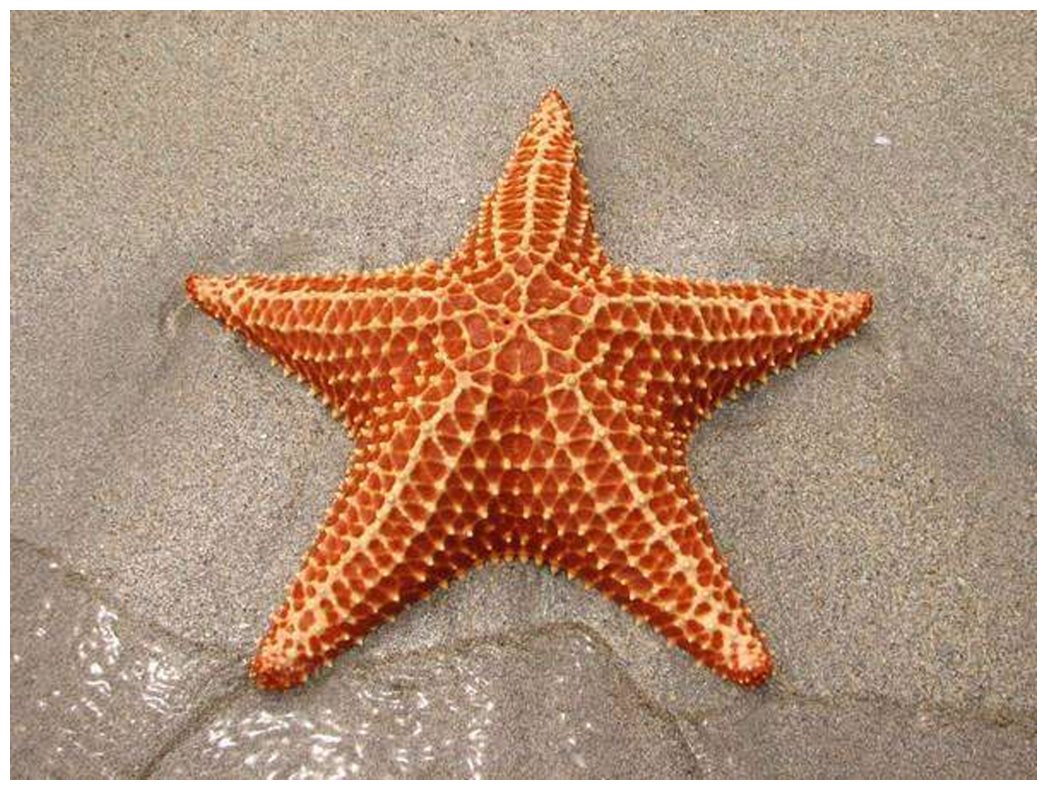

In [ ]:
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects
!./darknet detect img/yolov3.cfg yolov3_final.weights data/testando.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')